### **Google vision transformer**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader,Subset
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load the pre-trained ViT model and feature extractor
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

In [ ]:
# Modify the output layer to match the number of classes in CIFAR-10
num_classes = 10
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

In [ ]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to match the model's input size
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontally flip images with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Vertically flip images with a probability of 0.5
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply color jitter
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
    transforms.RandomRotation(60)
])

# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create a subset of the training dataset (10 images per class)
train_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_train_dataset.targets) if label == class_idx]
    train_subset_indices.extend(class_indices[:2000])
train_dataset = Subset(full_train_dataset, train_subset_indices)

# Create a subset of the test dataset (10 images per class)
test_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_test_dataset.targets) if label == class_idx]
    test_subset_indices.extend(class_indices[:500])

test_dataset = Subset(full_test_dataset, test_subset_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.classifier = model.classifier.to(device)  # Move the new output layer to the device

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Hyperparameters
num_epochs = 10
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
train_accuracies = []
train_top3_accuracies = []
train_losses = []
print('Performing training after data augmentation')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    top3_correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    lr_scheduler.step()  # Update the learning rate
    train_acc = 100 * correct / total
    train_top3_acc = 100 * top3_correct / total
    train_accuracies.append(train_acc)
    train_top3_accuracies.append(train_top3_acc)
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_acc:.2f}%, Train Top-3 Accuracy: {train_top3_acc:.2f}%")

Performing training after data augmentation
Epoch 1/10, Loss: 2.060705344009399, Train Accuracy: 22.06%, Train Top-3 Accuracy: 55.37%
Epoch 2/10, Loss: 1.9440686044692994, Train Accuracy: 26.58%, Train Top-3 Accuracy: 61.95%
Epoch 3/10, Loss: 1.8842462215423583, Train Accuracy: 29.21%, Train Top-3 Accuracy: 64.71%
Epoch 4/10, Loss: 1.74502699508667, Train Accuracy: 35.07%, Train Top-3 Accuracy: 70.79%
Epoch 5/10, Loss: 1.6799413410186768, Train Accuracy: 38.94%, Train Top-3 Accuracy: 72.70%
Epoch 6/10, Loss: 1.6338641424179077, Train Accuracy: 40.73%, Train Top-3 Accuracy: 74.32%
Epoch 7/10, Loss: 1.5676979892730714, Train Accuracy: 43.42%, Train Top-3 Accuracy: 76.39%
Epoch 8/10, Loss: 1.554166182899475, Train Accuracy: 43.61%, Train Top-3 Accuracy: 76.80%
Epoch 9/10, Loss: 1.546990818786621, Train Accuracy: 43.95%, Train Top-3 Accuracy: 77.12%
Epoch 10/10, Loss: 1.5339244829177856, Train Accuracy: 44.85%, Train Top-3 Accuracy: 77.56%


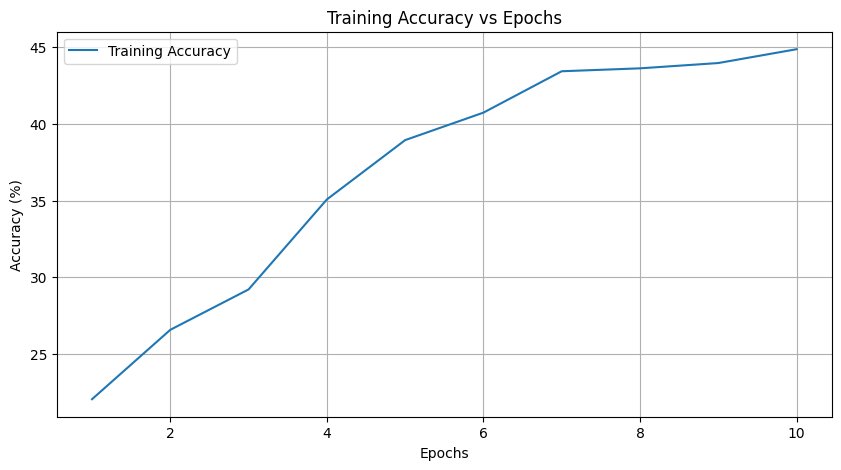

In [ ]:
# Plot training accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

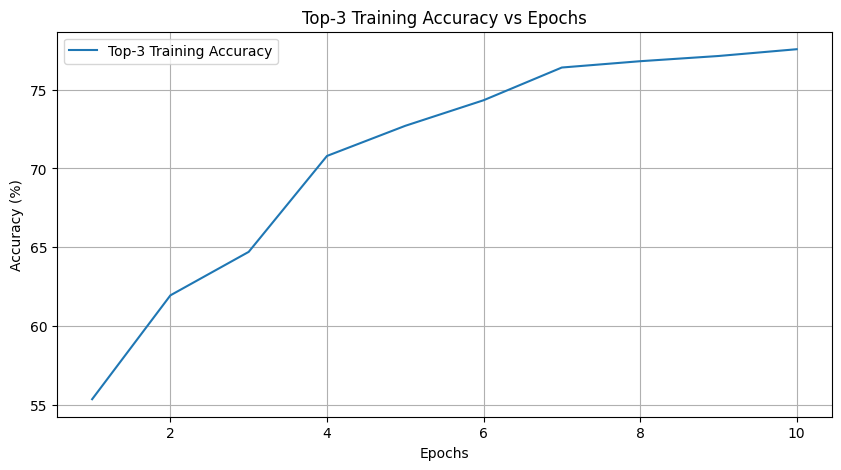

In [ ]:
# Plot top-3 train accuracies vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_top3_accuracies, label='Top-3 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Top-3 Training Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

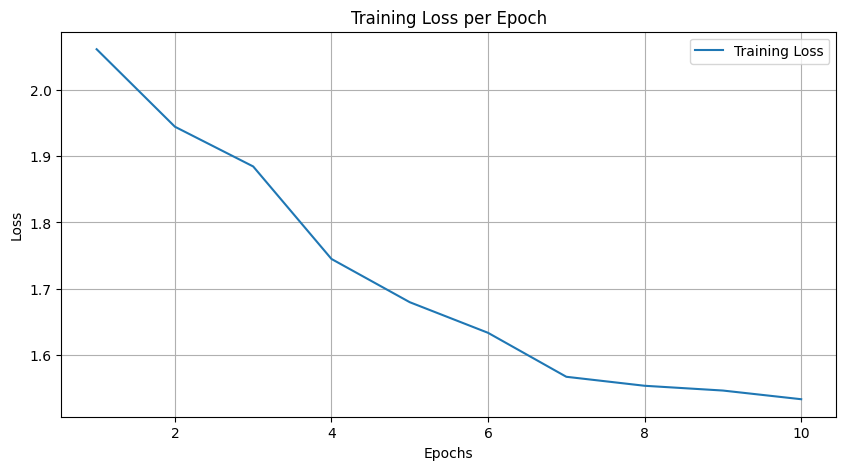

In [ ]:
# Plot loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Validation loop
model.eval()  # Set the model to evaluation mode
test_losses = []
test_accuracies = []
test_top3_accuracies = []

print('Performing validation')
with torch.no_grad():  # Disable gradient calculation during validation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-3 accuracy
        _, top3_predicted = outputs.logits.topk(3, dim=1)
        top3_predicted = top3_predicted.t()
        correct_per_batch = (top3_predicted == labels.view(1, -1)).float().sum(dim=0)
        top3_correct += correct_per_batch.sum().item()

    test_acc = 100 * correct / total
    test_top3_acc = 100 * top3_correct / total
    test_accuracies.append(test_acc)
    test_top3_accuracies.append(test_top3_acc)
    print(f"Validation Loss: {np.mean(test_losses):.4f}, Validation Accuracy: {test_acc:.2f}%, Validation Top-3 Accuracy: {test_top3_acc:.2f}%")


Performing validation
Validation Loss: 1.5726, Validation Accuracy: 44.68%, Validation Top-3 Accuracy: 77.39%
